In [1]:
!pip install torchsummary

In [2]:
!pip install torchmetrics

In [2]:
import warnings

warnings.filterwarnings('ignore')

import sys

if sys.version_info < (3,):
    raise Exception("pytorch_toolkit does not support Python 2. Please use a Python 3+ interpreter!")

import os
import random
import tarfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# torch imports
import torch
import torch.nn as nn
import torchmetrics
import torchsummary as ts
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

# seed random number generators
seed = random.randint(np.iinfo(np.uint32).min, np.iinfo(np.uint32).max)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

print(f"Using Pytorch {torch.__version__}. GPU {'is available :)' if torch.cuda.is_available() else 'is not available :)'}")
DEVICE = "cuda" if torch.cuda.is_available() else \
    ("dml" if (hasattr(torch, "dml") and torch.dml.is_available()) else "cpu")
print(f"Will train models on {DEVICE}")

Using Pytorch 1.8.0a0+b50919b. GPU is not available :)
Will train models on dml


In [3]:
def get_datasets(test_split=0.2, data_loc='./data'):

    """
    download the CIFAR10 dataset
    """
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, data_loc)

    data_file = os.path.join(data_loc, 'cifar10.tgz')
    assert os.path.exists(data_file),\
        f"FATAL ERROR: cannot find downloaded data file {data_file}"
    with tarfile.open(data_file, 'r:gz') as tar:
        tar.extractall(path=data_loc)

    train_images_folder = os.path.join(data_loc, 'cifar10', 'train')
    test_images_folder = os.path.join(data_loc, 'cifar10', 'test')

    assert os.path.exists(train_images_folder), \
        f"FATAL ERROR: train_images_folder ({train_images_folder}) does not exist!"
    assert os.path.exists(test_images_folder), \
        f"FATAL ERROR: train_images_folder ({test_images_folder}) does not exist!"

    train_dataset = ImageFolder(train_images_folder, transform=transforms.ToTensor())
    test_dataset = ImageFolder(test_images_folder, transform=transforms.ToTensor())

    print(f"No of downloaded training images = {len(train_dataset)}")
    print(f"No of downloaded test images = {len(test_dataset)}")

    # split test data into cross-val & test datasets
    num_test_recs = len(test_dataset)
    test_count = int(test_split * num_test_recs)
    val_count = num_test_recs - test_count
    print(f"Randomly splitting test dataset into cross-val dataset ({val_count} images) & test_dataset ({test_count} images)")

    val_dataset, test_dataset = \
      torch.utils.data.random_split(test_dataset, [val_count, test_count])
    print(f"After split")
    print(f"  - training records: {len(train_dataset)}")
    print(f"  - cross-val records: {len(val_dataset)}")
    print(f"  - test records: {len(test_dataset)}")
    return train_dataset, val_dataset, test_dataset

In [4]:
def display_sample(dataset):
    # display 64 random images from dataset
    labels_map = {
        0: "Plane",
        1: "Auto",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }
    figure = plt.figure(figsize=(12, 12))
    cols, rows = 8, 8
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.numpy().transpose((1, 2, 0)), cmap="Greys")
    plt.show()
    plt.close()

In [5]:
# convnet for image classification

def ConvLayer(inp, out, ks=3, s=1, p=1):
    net = nn.Sequential(
        nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p),
        nn.BatchNorm2d(out),
        nn.ReLU(),
    )
    return net

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.convNet = nn.Sequential(
            ConvLayer(3, 32),
            ConvLayer(32, 64),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.20),

            ConvLayer(64, 128),
            ConvLayer(128, 256),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25),

            ConvLayer(256, 512),
            ConvLayer(512, 1024),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.30),

            nn.Flatten(),

            nn.Linear(4 * 4 * 1024, 1024),
            nn.ReLU(),
            # nn.Dropout(p=0.20),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.20),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        # x = self.flatten(x)
        x = self.convNet(x)
        return x

In [6]:
def accuracy(logits, labels):
    acc = torchmetrics.functional.accuracy(logits, labels)
    return acc

In [7]:
def train_model(model, train_dataset, loss_fn, optimizer, val_dataset=None, epochs=5, batch_size=64):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    num_train_recs = len(train_dataset)
    num_batches = len(train_dataloader)
    num_val_recs = 0 if val_dataset is None else len(val_dataset)
    len_num_epochs, len_num_train_recs = len(str(epochs)), len(str(num_train_recs))

    # epoch-wise metrics history
    history = {
        'loss': [],
        'acc' : []
    }

    if val_dataset is not None:
        # also add validation metrics
        history['val_loss'] = []
        history['val_acc'] = []

    try:
        model = model.to(DEVICE)

        for epoch in range(epochs):
            epoch_train_loss, epoch_train_acc = 0.0, 0.0
            train_recs_so_far = 0

            for batch, (X, y) in enumerate(train_dataloader):
                X, y = X.to(DEVICE), y.to(DEVICE)
                pred = model(X)
                batch_loss = loss_fn(pred, y)
                batch_acc = accuracy(pred, y)
                epoch_train_loss += batch_loss
                epoch_train_acc += batch_acc

                # back prop
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                # display progress
                train_recs_so_far += len(X)
                print("\rEpoch (%*d/%*d): (%*d/%*d) -> loss: %.4f - acc: %.4f" %
                        (len_num_epochs, epoch+1, len_num_epochs, epochs,
                         len_num_train_recs, train_recs_so_far, len_num_train_recs, num_train_recs,
                         batch_loss, batch_acc), end="", flush=True)
            else:
                # all batches of train_dataset done, compute & display epoch train loss & acc
                epoch_train_loss /= num_batches
                epoch_train_acc /= num_batches

                # append epoch training metrics to history
                history['loss'].append(epoch_train_loss.item())
                history['acc'].append(epoch_train_acc.item())

                train_batch_end = "\n" if val_dataset is None else ""
                train_batch_continue = "" if val_dataset is None else "..."
                print("\rEpoch (%*d/%*d): (%*d/%*d) -> loss: %.4f - acc: %.4f%s" %
                        (len_num_epochs, epoch+1, len_num_epochs, epochs,
                         len_num_train_recs, train_recs_so_far, len_num_train_recs, num_train_recs,
                         epoch_train_loss, epoch_train_acc, train_batch_continue), end=train_batch_end, flush=True)

                if val_dataset is not None:
                    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                    val_loss, val_acc = 0.0, 0.0
                    num_val_batches = len(val_dataloader)

                    with torch.no_grad():
                        for batch, (X, y) in enumerate(val_dataloader):
                            X, y = X.to(DEVICE), y.to(DEVICE)
                            pred = model(X)
                            batch_loss = loss_fn(pred, y)
                            batch_acc = accuracy(pred, y)
                            val_loss += batch_loss
                            val_acc += batch_acc

                    val_loss /= num_val_batches
                    val_acc /= num_val_batches

                    # append to history
                    history['val_loss'].append(val_loss.item())
                    history['val_acc'].append(val_acc.item())

                    print("\rEpoch (%*d/%*d): (%*d/%*d) -> loss: %.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f" %
                            (len_num_epochs, epoch+1, len_num_epochs, epochs,
                            len_num_train_recs, train_recs_so_far, len_num_train_recs, num_train_recs,
                            epoch_train_loss, epoch_train_acc, val_loss, val_acc), flush=True)
        return history
    finally:
        model = model.to("cpu")


def evaluate_model(model, dataset, loss_fn, batch_size=64):
    try:
        model = model.to(DEVICE)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        loss, acc = 0.0, 0.0
        num_batches = len(dataloader)
        num_records, len_num_recs = len(dataset), len(str(len(dataset)))
        recs_so_far = 0

        with torch.no_grad():
            for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(DEVICE), y.to(DEVICE)
                pred = model(X)
                batch_loss = loss_fn(pred, y)
                batch_acc = accuracy(pred, y)
                loss += batch_loss
                acc += batch_acc
                recs_so_far += len(X)
                print("\rEvaluating (%*d/%*d) -> loss: %.4f - acc: %.4f" %
                            (len_num_recs, recs_so_far, len_num_recs, num_records, 
                             batch_loss, batch_acc), end='', flush=True)
            else:    
                loss /= num_batches
                acc /= num_batches

                print("\rEvaluating (%*d/%*d) -> loss: %.4f - acc: %.4f" %
                        (len_num_recs, recs_so_far, len_num_recs, num_records, 
                         loss, acc), flush=True)

        return loss.item(), acc.item()
    finally:
        model = model.to("cpu")

def predict_model(model, dataset, batch_size=64):
    try:
        model = model.to(DEVICE)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        preds, actuals = [], []

        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)

            # run prediction
            with torch.no_grad():
                model.eval()
                logits = model(X)
                batch_preds = list(logits.to("cpu").numpy())
                batch_actuals = list(y.to("cpu").numpy())
                preds.extend(batch_preds)
                actuals.extend(batch_actuals)
        return np.array(preds), np.array(actuals)
    finally:
        model = model.to("cpu")

def save_model(model, model_save_path, verbose=1):
    save_dir, _ = os.path.split(model_save_path)
    if not os.path.exists(save_dir):
        try:
            os.mkdir(save_dir)
        except OSError as err:
            print(f"Unable to create folder/directory {save_dir} to save model!")
            raise err

    torch.save(model.state_dict(), model_save_path)
    if verbose == 1:
        print(f"Pytorch model saved to {model_save_path}")

def load_model(model, model_state_dict_path, verbose=1):
    model_save_path = pathlib.Path(model_state_dict_path).absolute()
    if not os.path.exists(model_save_path):
        raise IOError(f"ERROR: can't load model from {model_state_dict_path} - file does not exist!")

    state_dict = torch.load(model_state_dict_path)
    model.load_state_dict(state_dict)
    if verbose == 1:
        print(f"Pytorch model loaded from {model_state_dict_path}")
    model.eval()

def show_plots(history, metric='acc', plot_title=None, fig_size=None):
    assert type(history) is dict

    assert 'loss' in history.keys(), \
        f"ERROR: expecting \'loss\' as one of the metrics in history object"
    if metric is not None:
        assert isinstance(metric, str), \
            "ERROR: expecting a string value for the \'metric\' parameter"
        assert metric in history.keys(), \
            f"{metric} is not tracked in training history!"

    loss_metrics = ['loss']
    if 'val_loss' in history.keys():
        loss_metrics.append('val_loss')

    other_metrics = []
    if metric is not None:
        assert metric in history.keys(), \
            f"ERROR: {metric} is not a metric being tracked!"
        other_metrics.append(metric)
        if f"val_{metric}" in history.keys():
            other_metrics.append(f"val_{metric}")

    col_count = 1 if len(other_metrics) == 0 else 2
    df = pd.DataFrame(history)

    with sns.axes_style("darkgrid"):
        sns.set_context("notebook", font_scale=1.2)
        sns.set_style(
            {"font.sans-serif": ["SF Pro Display", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(nrows=1, ncols=col_count,
                             figsize=((16, 5) if fig_size is None else fig_size))
        axs = ax[0] if col_count == 2 else ax

        # plot the losses
        losses_df = df.loc[:, loss_metrics]
        losses_df.plot(ax=axs)
        # ax[0].set_ylim(0.0, 1.0)
        axs.grid(True)
        losses_title = 'Training \'loss\' vs Epochs' if len(
            loss_metrics) == 1 else 'Training & Validation \'loss\' vs Epochs'
        axs.title.set_text(losses_title)

        # plot the metric, if specified
        if metric is not None:
            metrics_df = df.loc[:, other_metrics]
            metrics_df.plot(ax=ax[1])
            # ax[1].set_ylim(0.0, 1.0)
            ax[1].grid(True)
            metrics_title = f'Training \'{other_metrics[0]}\' vs Epochs' if len(other_metrics) == 1 \
                else f'Training & Validation \'{other_metrics[0]}\' vs Epochs'
            ax[1].title.set_text(metrics_title)

        if plot_title is not None:
            plt.suptitle(plot_title)

        plt.show()
        plt.close()


In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 32, 32, 3, 10
EPOCHS, BATCH_SIZE, LR, L2_REG = 25, 1024, 3e-3, 5e-3
MODEL_SAVE_PATH = './model_states/pytorch_cifar10.pyt'

## Model Training

In [9]:
# download the datasets
train_dataset, val_dataset, test_dataset = get_datasets(data_loc='./data')
print(f"Training dataset: {len(train_dataset)} records")
print(f"Cross-val dataset: {len(val_dataset)} records")
print(f"Testing dataset: {len(test_dataset)} records")

Using downloaded and verified file: ./data\cifar10.tgz
No of downloaded training images = 50000
No of downloaded test images = 10000
Randomly splitting test dataset into cross-val dataset (8000 images) & test_dataset (2000 images)
After split
  - training records: 50000
  - cross-val records: 8000
  - test records: 2000
Training dataset: 50000 records
Cross-val dataset: 8000 records
Testing dataset: 2000 records


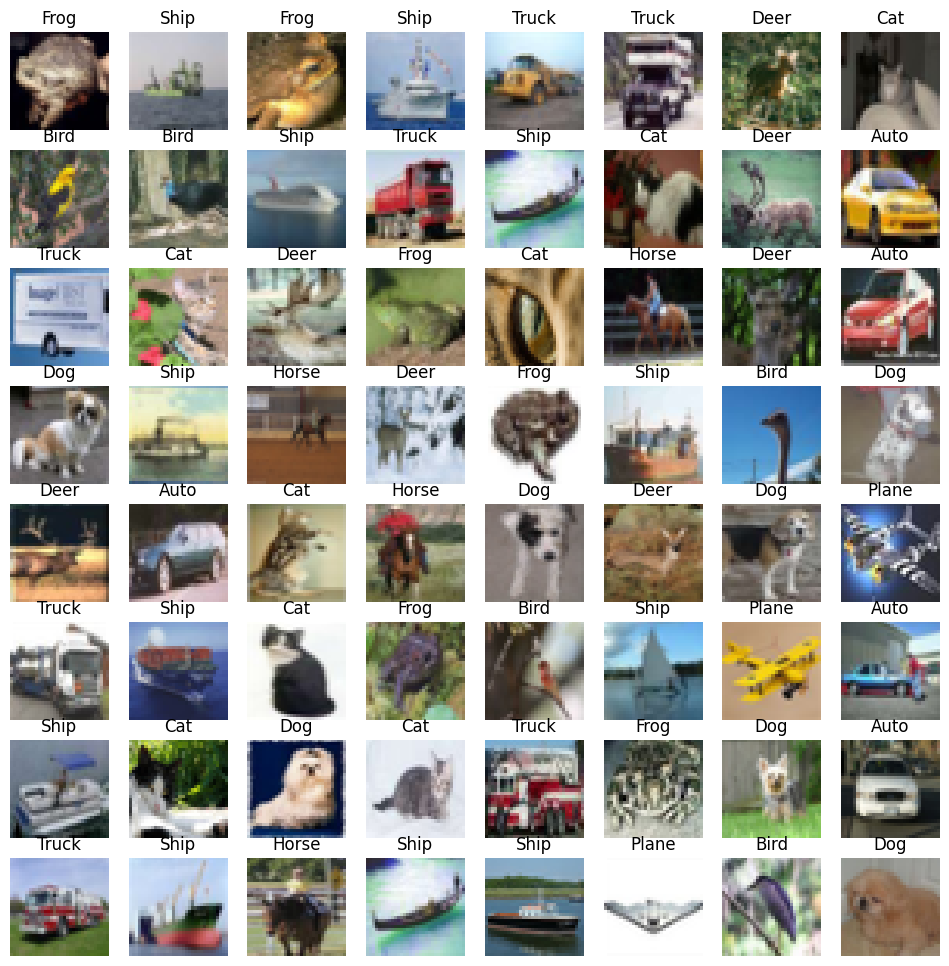

In [11]:
# display a random sample from test dataset
display_sample(test_dataset)

In [12]:
def build_model():
    model = ConvNet()
    model = model.to(DEVICE)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=L2_REG)
    return model, loss_fn, optimizer

In [14]:
# build the model
model, loss_fn, optimizer = build_model()
# print(ts.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

In [15]:
# train the model
hist = train_model(model, train_dataset, loss_fn, optimizer, val_dataset=val_dataset, 
                   epochs=EPOCHS, batch_size=BATCH_SIZE)

RuntimeError: Could not run 'aten::argmax' with arguments from the 'DML' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::argmax' is only available for these backends: [CPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at D:\a\_work\1\s\pytorch-directml\build\aten\src\ATen\RegisterCPU.cpp:5926 [kernel]
BackendSelect: fallthrough registered at D:\a\_work\1\s\pytorch-directml\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at D:\a\_work\1\s\pytorch-directml\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradCPU: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradCUDA: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradXLA: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradNestedTensor: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradPrivateUse1: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradPrivateUse2: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
AutogradPrivateUse3: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\VariableType_0.cpp:9283 [autograd kernel]
Tracer: registered at D:\a\_work\1\s\pytorch-directml\torch\csrc\autograd\generated\TraceType_0.cpp:10499 [kernel]
Autocast: fallthrough registered at D:\a\_work\1\s\pytorch-directml\aten\src\ATen\autocast_mode.cpp:250 [backend fallback]
Batched: registered at D:\a\_work\1\s\pytorch-directml\aten\src\ATen\BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at D:\a\_work\1\s\pytorch-directml\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]


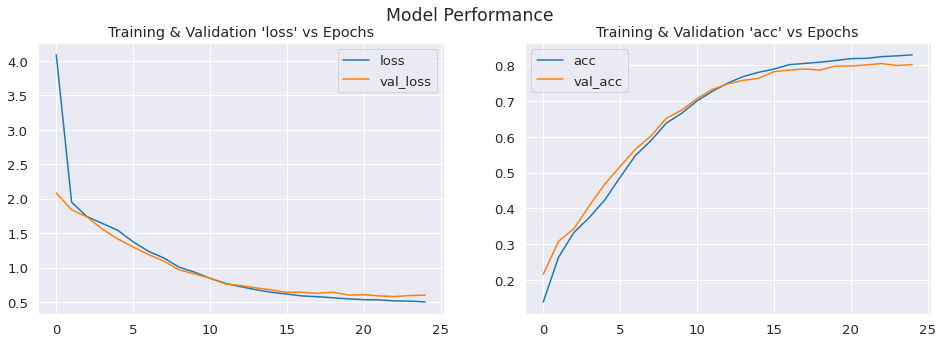

In [ ]:
show_plots(hist, metric='acc', plot_title='Model Performance')

In [ ]:
# evaluate model performance
print('Evaluating performance...')
loss, acc = evaluate_model(model, train_dataset, loss_fn, batch_size=1024)
print(f'  - Training dataset: loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = evaluate_model(model, val_dataset, loss_fn, batch_size=1024)
print(f'  - Cross-val dataset: loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = evaluate_model(model, test_dataset, loss_fn, batch_size=1024)
print(f'  - Test dataset: loss: {loss:.4f} - acc: {acc:.4f}')

Evaluating performance...
Evaluating (50000/50000) -> loss: 3.0010 - acc: 0.2648
  - Training dataset: loss: 3.0010 - acc: 0.2648
Evaluating (8000/8000) -> loss: 0.5945 - acc: 0.7991
  - Cross-val dataset: loss: 0.5945 - acc: 0.7991
Evaluating (2000/2000) -> loss: 0.5796 - acc: 0.8081
  - Test dataset: loss: 0.5796 - acc: 0.8081


In [ ]:
save_model(model, MODEL_SAVE_PATH)
del model

Pytorch model saved to /tmp/pytorch_cifar10.pyt


In [85]:
# load model state
model, loss_fn, optimizer = build_model()
print(ts.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))
load_model(model, MODEL_SAVE_PATH)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         295,168
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-14          [-1, 256,

NameError: ignored

In [ ]:
# evaluate model
print('Evaluating performance...')
loss, acc = evaluate_model(model, train_dataset, loss_fn, batch_size=1024)
print(f'  - Training dataset: loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = evaluate_model(model, val_dataset, loss_fn, batch_size=1024)
print(f'  - Cross-val dataset: loss: {loss:.4f} - acc: {acc:.4f}')
loss, acc = evaluate_model(model, test_dataset, loss_fn, batch_size=1024)
print(f'  - Test dataset: loss: {loss:.4f} - acc: {acc:.4f}')    

Evaluating performance...
Evaluating (60000/60000) -> loss: 0.1294 - acc: 0.9558
  - Training dataset: loss: 0.1294 - acc: 0.9558
Evaluating (8000/8000) -> loss: 0.2053 - acc: 0.9276
  - Cross-val dataset: loss: 0.2053 - acc: 0.9276
Evaluating (2000/2000) -> loss: 0.2072 - acc: 0.9294
  - Test dataset: loss: 0.2072 - acc: 0.9294


In [ ]:
print('Running predictions...')
y_pred, y_true = predict_model(model, test_dataset, batch_size=64)
y_pred = np.argmax(y_pred, axis=1)
print('Sample labels (50): ', y_true[:50])
print('Sample predictions: ', y_true[:50])
print('We got %d/%d incorrect!' %
        ((y_pred != y_true).sum(), len(y_true)))

Running predictions...
Sample labels (50):  [4 2 8 5 7 6 7 2 4 7 4 1 8 5 9 1 5 8 6 8 8 3 1 8 2 5 6 9 2 4 0 1 0 5 6 0 1
 5 6 7 7 6 6 6 9 0 2 3 7 0]
Sample predictions:  [4 2 8 5 7 6 7 2 4 7 4 1 8 5 9 1 5 8 6 8 8 3 1 8 2 5 6 9 2 4 0 1 0 5 6 0 1
 5 6 7 7 6 6 6 9 0 2 3 7 0]
We got 141/2000 incorrect!


In [ ]:
del model